In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Uncomment this to run on GPU
dtype = torch.float


Bad key "text.kerning_factor" on line 4 in
/home/mahogny/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [75]:
######## Definition of the neural network 
class Regressor(nn.Module):
    def __init__(self, num_feature):
        super().__init__()    
        self.fc1 = nn.Linear(num_feature, 16) 
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [61]:
######## Read data
#dataCSV = pd.read_csv("/home/gabija/Downloads/for_gabija.csv")   
#dataCSV = pd.read_csv("/home/gabija/Downloads/glialcell.csv")   
#dataCSV = pd.read_csv("greta/feature/macrophage.csv")   
dataCSV = pd.read_csv("greta/feature/T cell.csv")   
#dataCSV = pd.read_csv("greta/feature/B cell.csv")   

dataCSV = dataCSV.drop(columns=['rank_gwas_1', 'rank_tad', 'essentiality_ct'])


######## Prepare test and train datasets
data = pd.DataFrame(dataCSV)
X = data.iloc[:,6:]  #remove first descriptive cols
y = data["rank_pmid"]  #Predict rank_pmid
orig_year = data["orig_year"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

######## Prepare training input for pytorch; split it in batches
batch_size = 50
train_batch = np.array_split(X_train, batch_size)
label_batch = np.array_split(y_train, batch_size)
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)

######## Prepare test input for pytorch
X_val = torch.from_numpy(X_test.values).float()
y_val = torch.from_numpy(y_test.values).float().view(-1, 1)



Epoch: 1/40..  Training Loss: 0.662..  Test Loss: 0.779.. 
Epoch: 2/40..  Training Loss: 0.583..  Test Loss: 0.763.. 
Epoch: 3/40..  Training Loss: 0.561..  Test Loss: 0.754.. 
Epoch: 4/40..  Training Loss: 0.548..  Test Loss: 0.748.. 
Epoch: 5/40..  Training Loss: 0.542..  Test Loss: 0.746.. 
Epoch: 6/40..  Training Loss: 0.539..  Test Loss: 0.745.. 
Epoch: 7/40..  Training Loss: 0.537..  Test Loss: 0.744.. 
Epoch: 8/40..  Training Loss: 0.535..  Test Loss: 0.743.. 
Epoch: 9/40..  Training Loss: 0.533..  Test Loss: 0.742.. 
Epoch: 10/40..  Training Loss: 0.531..  Test Loss: 0.742.. 
Epoch: 11/40..  Training Loss: 0.530..  Test Loss: 0.741.. 
Epoch: 12/40..  Training Loss: 0.529..  Test Loss: 0.741.. 
Epoch: 13/40..  Training Loss: 0.528..  Test Loss: 0.740.. 
Epoch: 14/40..  Training Loss: 0.527..  Test Loss: 0.740.. 
Epoch: 15/40..  Training Loss: 0.527..  Test Loss: 0.740.. 
Epoch: 16/40..  Training Loss: 0.526..  Test Loss: 0.740.. 
Epoch: 17/40..  Training Loss: 0.526..  Test Loss

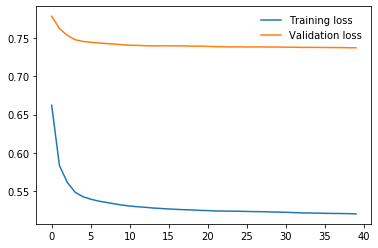

In [76]:
######## Train the model
model = Regressor(X.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 40

train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    
    ## Train the network, batch by batch
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        #print(output)
        loss = criterion(output, label_batch[i]) #this is modified with log removed
        #print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    else:
        train_losses.append(train_loss/len(train_batch))
        
        
        ## Check the model on the test set
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(predictions, y_val))
        test_losses.append(test_loss)

        ## Current stats after one batch
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.3f}.. ".format(test_loss))

######## Plot the progress of the training
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig("plots/SimpleNN_convergence.pdf")

0.5448239


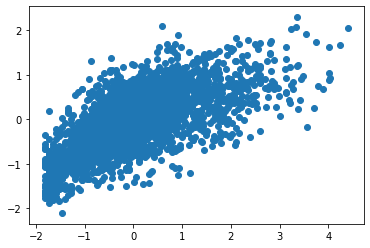

In [71]:
#################################################################
##Function: Get the prediction from some data, as numpy array
def predict_for(X):
    with torch.no_grad():
        model.eval()
        output = model.forward(X) #Test 
    return output.numpy()


######## Plot predicted rank_pmid vs real rank_pmid
y_val_predicted = predict_for(X_val)
plt.scatter(y_val, y_val_predicted)  #X: real data, Y: predicted
print(mean_squared_error(y_val, y_val_predicted))


In [72]:
#### Sensitivity analysis
X_test_col = X_test.columns.tolist()
y_val_predicted = predict_for(X_val)
X_test_diff = X_test.copy()

outlist=[]

for i in range(0, len(X_test_col)):
    the_feature = X_test_col[i]
    X_test_perturb = X_test.copy()
    X_test_perturb[the_feature] = X_test_perturb + X_test[the_feature].std()
    y_val_perturbed_predicted = predict_for(torch.from_numpy(X_test_perturb.values).float())
    
    X_test_diff[the_feature] = y_val_perturbed_predicted - y_val_predicted
    diff = ((y_val_perturbed_predicted - y_val_predicted)).mean()
    
    outlist.append(diff)

    
df = pd.DataFrame(list(zip(X_test_col, outlist)), 
               columns =['feature', 'val']) 
df = df.sort_values(by="val")

df.to_csv("plots/SimpleNN_out_weight.csv")
df

,feature,val
5,first_year,-0.602210
6,family_indexdiff,-0.189587
4,ppi,0.031289
9,rank_gwas,0.036978
1,coexp10,0.057674
3,nearby_pmid,0.062263
10,homology_pmid,0.066899
2,essentiality_global,0.089084
8,rank_cosmic,0.108288
0,rank_exp,0.119553


In [ ]:
######## Definition of the neural network   ---- v3
class Regressor(nn.Module):
    def __init__(self, num_feature):
        super().__init__()    
        self.fc1 = nn.Linear(num_feature, 16) 
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
######## Definition of the neural network   ---- for testing
class Regressor(nn.Module):
    def __init__(self, num_feature):
        super().__init__()    
        self.fc1 = nn.Linear(num_feature, 16) 
        #self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))

        return x

In [ ]:
######## Definition of the neural network   ---- most basic, linear regression
class Regressor(nn.Module):
    def __init__(self, num_feature):
        super().__init__()    
        self.fc1 = nn.Linear(num_feature, 1) 
        #self.fc3 = nn.Linear(32, 16)
        #self.fc4 = nn.Linear(16, 1)
        #self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.dropout(F.relu(self.fc3(x)))
        #x = self.fc4(x)
        
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))

        return x